## Milvus社区问题汇总

----

### 关于Milvus版本升级

- 升级路线，推荐 2.3.x——>2.3最新版——>2.4最新版——>2.5最新版 --> 2.6 ...
- 2.4目前最稳定的小版本是 2.4.23。记住一个通用原则，第三位小版本号越大，越稳定。

### 内存：省一点，再省一点

- “partition key 也是很多人在一个集合里吗？可不可以一个人一个人的释放占用的内存”
- “因为我在插入数据到时候报错内存不足，所以我想算一下需要多少。”
- “标量是不是不建议 load 内存中，感觉几十 G 的内存几下就用完了。”
- “数据如果一直都有写入，那 load 后的集合会越来越占内存，不知道其他人有没有什么好的方案能在内存和查询速度上做出平衡？”

以上是关于“内存”关键词的相关讨论。向量作为一种新的数据类型，天然具有维度高的属性。为了获取优异性能，向量被读取到内存做计算也成了通用的做法。但是，随着数据规模的增加，内存余量逐渐见底，在全行业都在降本增效的时代，如何省更多内存成为了所有开发者的心声。当然，直至今日，Milvus 对于内存的优化也从未停止，社区的目标永远都是“省一点，再省一点”。

但是，作为一个数据库系统，不可能同时满足内存低、性能好、精度高的条件。一般都需要牺牲性能或者精度，来换取内存开销的降低。可以用下面这张图来表示目前常见降低内存使用的方法：

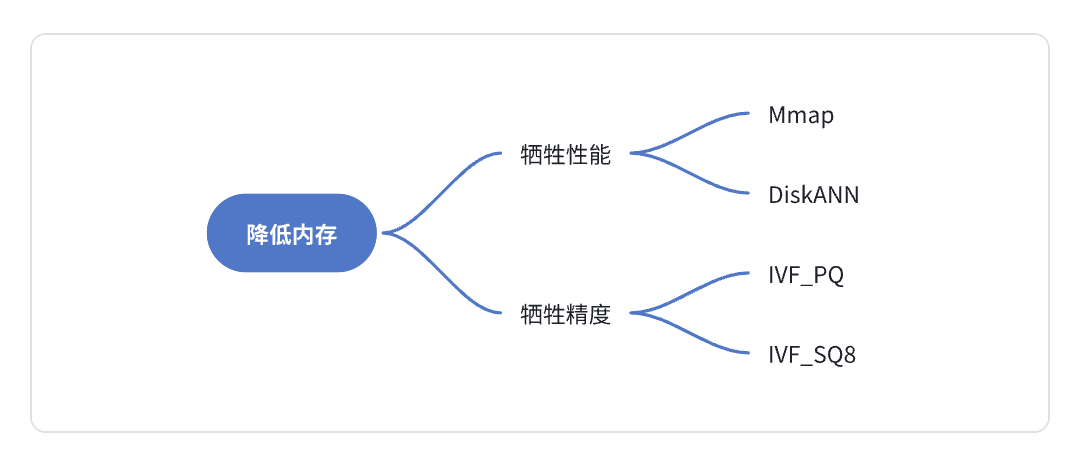

----

### 插入：丝滑入库是影响开发体验的第一步

“插入”应该是使用最多的一个数据库操作，所有后续的工作也是建立在数据成功插入的基础上。丝滑的入库体验，是影响开发体验的第一步，也是至关重要的一步。

Milvus 社区对于“插入”的讨论，主要集中在数据插入的实践经验上：

- “插入的速度怎么优化啊？”
- “分批插入数据，是每一批 collection.flush()，还是最后再 collection.flush()？”
- “这个设置成主键之后，为什么还可以继续重复插入相同的值？”

关于这一关键词，和大家分享 3 点关于数据插入的心得：

- 批量插入快于单条插入，文件导入（bulk_insert）快于批量插入（insert）。普通 insert 接口，数据入库需要经过 Proxy—>MQ—>DataNode—Object Storage 这样较长的一套流程。但是文件导入 bulk_insert 的入库流程仅为：Proxy—>DataNode—Object Storage，可以减少耗时较长的 MQ 环节。对于大批量（千万以上）的数据导入，强烈建议使用 bulk_insert 接口。
- 插入数据时，不要每一批都调用 flush()接口，Milvus 内部会定期调 flush() 接口，所有数据都插入完成之后，再调用一次 flush 即可。插入数据后，频繁调用 flush，会产生大量碎的 segment 文件，为系统带来较大的 compaction 压力。
- Milvus 用 insert 接口做数据插入时，不会做主键去重，如果希望主键去重，可以使用 upsert 接口。但是，由于 upsert 内部多做了一次 query 操作，插入性能会比 insert 更差。

-----

### 配置：半数使用问题是配置问题

- “Milvus 配置用户名密码进行校验，需要怎么开启呢？”
- “这个服务通过 k8s 已经起来的，我在不想关闭他的情况下应该怎么修改配置文件呢？”
- “etcd 如果独立部署的话，这块儿的配置有推荐的参考值吗？”

Milvus 作为一个分布式向量数据库，除了自身有较多的功能模块，同时还依赖对象存储、消息队列、etcd 等第三方组件。为了保证 Milvus 集群在不同应用场景中均能发挥出最佳性能，Milvus 暴露了大量的配置参数。但是面对这些配置参数，“调哪个”“怎么调”“调多大” 成了很多用户所遇到的难题。可以说，如果把 Milvus 的配置参数调明白了，Milvus 一半的使用问题都解决了。

关于“调哪个”的问题，这是配置这三个问题中最难的，不同的使用场景下，要调的参数都是不同的。就拿性能优化这件事情来说，搜索性能优化的参数和插入性能优化的参数肯定是不一样的，这就比较依赖于实际使用的经验。Zilliz（Milvus 原厂）的官方公众号上，有很多 Milvus 的资深研发同学和 Milvus 深度用户写的技术文章，里面提到了很多配置调优经验，大家可以将这块的资源充分利用起来。

[**Milvus 配置详解**](https://mp.weixin.qq.com/s?__biz=MzUzMDI5OTA5NQ==&mid=2247496778&idx=1&sn=018256ae415356e3ed357ee473dc1627&chksm=fa5155f2cd26dce4095b57fa4eb5c7e67e9eb49ed2762ce618e1134bb33022049e75c25e49ab&scene=21#wechat_redirect)








## 优化 Milvus 性能

------

### 经验1： 合理的预计数据量，表数目大小，QPS 参数等指标

在部署 Milvus 之前，首先需要决定机器的资源、规格、以及一些依赖的资源，以下是你需要考虑的因素：

- 有多少张表？
- 每张表的数据量有多少？
- 每张表的 QPS 需求有多少？
- 是否需要存标量字段，如果有字符串，字符串的平均长度是多少？
- 是否有删除和流式插入，每天大概有多少比例的数据需要被更新？
  
基于以上因素，可以遵循以下经验结论：

- 节点资源占用可以通过 [sizing tool](https://milvus.io/tools/sizing/) 进行计算，通常情况下 8G 内存可以支持超过 5m 的 128dim 向量数据和 1m 的 768dim 数据。
- 默认情况下，Milvus 会创建 256 个消息队列 topic。如果表数目比较少，可以调整 `rootCoord.dmlChannelNum` 减少 topic 数目降低消息队列负载。
- 默认情况下，每个 collection 会使用 2 个消息队列 topic（shard），如果写入非常大或者数据量极大，需要调整 collection 的 shard 数目。建议每个 shard 写入/删除不超过 10M/s，单个 shard 的数据量不大于 1B 向量，shard 数目过大也会影响写入性能，因此不建议单表超过 8 个 shard。
- 根据 [benchmark](https://milvus.io/docs/benchmark.md) 结果计算需要的 CPU 资源。对于小数据量场景（小于5m），使用多副本可以扩展查询性能，但建议副本数目不要超过 10 个。对于中大数据量场景，通常扩容 querynode 就可以自动负载均衡，不需要使用多副本提升 QPS.
- 所有的标量字段目前也会加载进内存中，也会消耗内存，请在容量规划时预留原始数据类型两倍以上的内存。
- Milvus 在存储数据的过程中，存在较多冗余数据（https://github.com/milvus-io/milvus/issues/20453）。考虑到 Minio 的 2，4 纠删码存在两副本冗余，我们建议 Minio 至少包含 6 倍以上的数据的磁盘存储。同时 Pulsar/Kafka 需要包含近五天写入量三倍的存储。合理调整数据的保留时间和 GC 时间可以很大程度上减少磁盘的使用，默认情况下数据会被保留 5 天。个人建议适当缩短数据过期时间，但尽可能保留 1 天以上避免数据丢失或误删除。
- Etcd 作为 Milvus 的元信息存储和服务发现节点，请尽可能使用 ssd 磁盘并独立部署。通常 Etcd 的内存使用不会超过 4GB，通过调整参数可以较快地清理 etcd 中的历史版本减少内存使用。
- Pulsar/Kafka 作为 Milvus 的日志存储，其依赖的 zookeeper 集群对性能要求也比较高，建议使用 SSD 并独立部署。

----

### 经验2: 选择合适的索引类型和参数

索引的选择对于向量召回的性能至关重要，Milvus 支持了 Annoy，Faiss，HNSW，DiskANN 等多种不同的索引，用户可以根据对延迟、内存使用和召回率的需求进行选择。

索引的选择步骤一般如下：

- 1） 是否需要精确结果？
  - 只有 Faiss 的 Flat 索引支持精确结果，但需要注意 Flat 索引检索速度很慢，查询性能通常比其他 Milvus 支持的索引类型低两个数量级以上，因此只适合千万级数据量的小查询（Flat on GPU 已经在路上了，敬请期待）

- 2）数据量是否能加载进内存？
  - 对于大数据量，内存不足的场景，Milvus 提供两种解决方案：
    - DiskANN
      - DiskANN 依赖高性能的磁盘索引，借助 NVMe 磁盘缓存全量数据，在内存中只存储了量化后的数据。
      - DiskANN 适用于对于查询 Recall 要求较高，QPS 不高的场景。
      - DiskANN 的关键参数：
        - **search_list**: search_list 越大，recall 越高而性能越差。search_list 的大小不应该小于 K。而对于较小的 K，推荐把 search_list 和 K 的比值设置得相对大一些, 这个比值随着 K 增大可以逐渐靠近 1。
    - IVF_PQ
      - 对于精确度要求不高的场景或者性能要求极高的场景。
      - IVF PQ 的核心是两个算法，IVF + PQ 量化，其中量化可以大幅减少向量的占用内存量。
        - IVF 参数
          - **nlist**：一般建议 nlist = 4*sqrt(N)，对于 Milvus 而言，一个 Segment 默认是 512M 数据，对于 128dim 向量而言，一个 segment 包含 100w 数据，因此最佳 nlist 在 1000 左右。
          - **nprobe**：nprobe 可以 Search 时调整搜索的数据量，nprobe 越大，recall 越高，但性能越差。具体的 nprobe 需要根据查询的精度要求决定，从 nprobe = 16 开始会是一个不错的尝试。
        - PQ 参数
          - **M**: 向量做 PQ 的分段数目，一般建议设置为向量维数的 1/4，M 取值越小内存占用越小，查询速度越快，精度也变得更加低。
          - **N bits**: 每段量化器占用的 bit 数目，默认为 8，不建议调整。
- 3） 构建索引和内存资源是否充足
  - **性能优先，选择 HNSW 索引**
    - HNSW 索引是目前 Milvus 支持的性能最快的索引，我们的测试报告也是基于 HNSW 作为测试依据。
    - HNSW 内存的开销较高，通常需要原始向量的 1.5 - 2 倍以上内存。
    - HNSW 参数
      - M：表示在建表期间每个向量的边数目，M 越大，内存消耗越高，在高维度的数据集下查询性能会越好。通常建议设置在 8-32 之间。
      - ef_construction：控制索引时间和索引准确度，ef_construction 越大构建索引越长，但查询精度越高。要注意 ef_construction 提高并不能无限增加索引的质量，常见的 ef_constructio n 参数为 128。
      - ef: 控制搜索精确度和搜索性能，注意 ef 必须大于 K。
  - **资源优先，选择 IVF_FLAT 或者 IVF_SQ8 索引**
    - IVF 索引在 Milvus 分片之后也能拿到比较不错的召回率，其内存占用和建索引速度相比 HNSW 都要低很多
    - IVF_SQ8 相比 IVF，将向量数据从 float32 转换为了 int8，可以减少 4 倍的内存用量，但对召回率有较大影响，如果要求 95% 以上的召回精度不建议使用。
    - IVF 类索引的参数跟 IVFPQ 类似，这里就不做过多的介绍了。
  - 检索时，Milvus 的**查询一致性**也会对查询造成较大影响。通常情况，对于一致性要求较高的场景，建议使用最终一致性或者有界一致，默认情况下 Milvus 选择有界一致性，窗口为 3s。

-----

### 经验3: 合理选择流式插入和批量导入

Mivus 原生支持流批一体，同时支持流式写入和批式写入(BulkInsert)两种模式。绝大多数用户在最初接触 Milvus 的时候，都会选择流式写入，这种方式实时性较好，同时也避免了批式写入小文件带来的 Compaction 压力。

如果有大量离线写入的场景，建议使用 BulkInsert，原因是 BulkInsert 不会对查询性能造成太大的影响，并且也大大减少了流式写入对消息队列产生的压力。如何合理选择流式还是批式写入呢：

- 单次写入超过 100MB 以上，建议选择批式写入
- 希望尽可能减少写入对线上查询的影响，建议选择批式写入
- 希望写入实时可见，建议选择流式写入
- 单次写入小于 10MB 以下，建议选择流式写入

在选择好写入方式的基础上，还有几个经验需要关注：

- 尽可能批量写入，整体吞吐会更高，建议每次写入的大小控制在 10M
- 单个 Shard 的流式写入量不建议超过 10M/s
- Datanode 多于 Shard 的情况下，部分 DataNode 可能无法获得负载
- 导入目前支持的文件大小上限是 1GB，接下来会支持更大的导入文件大小上限
- 不建议频繁导入小文件，会给 compaction 带来比较大的压力

----

### 经验4: 谨慎使用标量过滤，删除特性等特性

作为数据库，Milvus 支持了删除、标量过滤、TimeTravel 等高级特性。如果不了解底层原理，使用这些高级功能可能会对稳定性和性能造成比较严重的影响，以下是一些使用注意事项：

- Milvus 使用的是前过滤，即先做标量过滤生成 Bitset，在向量检索的过程中基于 Bitset 去除掉不满足条件的 entity。对于 HNSW 这一类的图索引而言，标量过滤并不会加速查询，反而可能导致性能变差。特别是对于过滤性很强的条件（比如 PK=1 这种全局唯一的条件），标量过滤甚至会导致单次查询的时间长于爆搜。针对这种情况，用户也可以选择通过后过滤的方式绕过，先基于 Milvus 查出 TopK 的数据，再基于其他数据库进行过滤。
- 对于过滤条件相对比较确定的场景，使用 Partition 把数据进行物理分区，在查询的时候指定 Partition 性能更好。
- Milvus 的删除是标记删除，在 compaction 时会清理，因此删除的数据依然会占据内存。大量删除也会造成查询性能下降，同时大量 compaction 可能造成建索引压力变大等一系列影响。在需要大量频繁删除的场景，可能需要进行一些 compaction 参数的调整，保证删除的数据能够被及时清理。
- Milvus 支持了数据自动过期功能（TTL），可以定时清理过期数据。
- 如果需要全量更新一个 Collection 的数据，推荐使用新建表 + 导入数据 + Alias 切换的方案。
- 制定 Output field 时，如果要获取标量字段，会从对象存储上获取，吞吐和延迟都会受到较大影响。

当然，Milvus 后续的版本会对以上能力做针对性的优化，尤其是删除和标量过滤的场景。Milvus 新一代的标量执行引擎也已经在开发中，欢迎大家参与给出更多有建设性的意见。

----

### 经验5: 部署监控并观察集群情况

可观测性是用户在生产环境落地非常重要的一部分，Milvus 2.2 重新梳理监控指标并且校正了指标的正确性，我们强烈建议你的生产集群部署监控并且在上线之前进行性能测试。

以下是一些建议你关注的监控指标：

- Proxy
  - 查询延迟：milvus_proxy_sq_latency/milvus_proxy_collection_sq_latency
  - 写入/删除延迟：milvus_proxy_mutation_latency
  - 写入流量：milvus_proxy_receive_bytes_count
  - 查询返回流量：milvus_proxy_send_bytes_count
- QueryNode
  - 加载的数据量：milvus_querynode_entity_num
  - 查询请求排队时间：milvus_querynode_sq_queue_latency
  - 单个 Segment 的查询时间：milvus_querynode_sq_segment_latency
- IndexNode
  - 构建索引的时间：milvus_indexnode_build_index_latency
- DataNode
  - Flush 花费的时间：milvus_datanode_save_latency
  - Compaction 花费的时间：milvus_datanode_compaction_latency

-----

### 经验6: 一些常见的参数调整

想要使得 Milvus 跑得更快更稳，针对自己的使用场景、硬件资源情况进行一些定制化的调整自然是不可避免的，你可以从了解以下参数开始：

- **Segment 大小**：Segment 大小越大，查询性能越好，构建索引越慢，负载越不容易均衡。Milvus 默认选择 512M Segment 大小主要是考虑到了内存比较少的机型。对于内存在 8G-16G 的用户，建议 Segment 大小调整到 1024M，16G 以上的机型可以调整到 2G。

- **Segment seal portion**: 当 Growing Segment 达到 Segment 大小 * seal portion 后，流式数据就会被转换为批数据。通常情况下建议 Growing segment 的大小控制在 100-200M 左右，调小这个值有助于降低流式写入场景下的查询延迟。

- **DataNode Segment SyncPeriod**: Milvus 会定时将数据 Sync 到对象存储，Sync 越频繁故障恢复速度越快，但过于频繁的 sync 会导致 Milvus 生产大量小文件，给对象存储造成较大压力。

- **Quota 相关的参数**：目前支持限制 Milvus 的写入、删除流量、查询的 QPS，以及内存的保护，当触发性能问题时，也要观察是否是因为触发了相应的限流。






## 加速Milvus实践: 从资源配置到参数调优

------

### Overview

随着检索增强生成（RAG）技术的兴起，**向量数据库日益成为业界关注的焦点**。**Milvus作为一款广受欢迎的开源向量数据库，已被众多开发者和企业广泛部署于实际应用中**。社区对于Milvus性能调优的需求也日益增长。

基于团队在工程开发及概念验证（PoC）项目中的实践经验，总结了若干性能调优的关键方向。在深入探讨调优策略之前，需要明确Milvus的资源消耗主要集中在哪些环节。向量数据库与传统数据库的核心差异在于**向量搜索**。在绝大多数场景下，**向量搜索都占据了Milvus绝大部分的计算资源**。因此，本次讨论将聚焦于如何加速向量计算，主要涵盖以下两大类方法：
*   其一，最直接的手段是**增加物理资源**。但在分布式系统中，如何合理地分配新增资源以达到最优效果，是一个值得探讨的问题。
*   其二，向量搜索的效率高度依赖于**向量索引**。将深入剖析不同向量索引的特性，探讨如何进行参数调优。具体而言，哪些参数是可调的？哪些参数对性能影响最为显著？

需要强调的是，**任何调优策略都伴随着相应的代价权衡**，请务必在充分理解业务需求和系统影响的前提下谨慎实施。

-------

### 1. 物理资源配置
对于一个分布式系统来说，增加物理资源并不是立即发挥作用。Milvus需要**显式地将资源分配给特定的功能模块**。

对性能影响最大的两个模块是：
*   **`index_node`**：影响**向量索引的构建性能**，外在表现即**构建速度**。
*   **`query_node`**：影响**向量索引的搜索性能**，外在表现即**Search Latency和QPS** (Queries Per Second)。

Milvus支持**动态扩缩容**。例如，如果用户需要搭建一个只读系统，数据是一次性灌入，后续不会有数据更新，那么最佳实践是：在插入数据时，**尽可能增加`index_node`的数量或者调大单个`index_node`的资源**。索引构建完毕以后，可以下掉多余的`index_node`，将资源倾斜至`query_node`。

生产场景下，Milvus提供了更多运维工具的支持 (prometheus/grafana)，用户可以根据实际业务量的变化，手动调整一个合适的架构比例，充分利用资源。

除了node数量外，**物理机的底层架构**也是重要的影响因素之一。向量索引的操作是**计算密集型task**。Milvus的性能瓶颈大多数情况下出现在**CPU**（开启mmap或者diskann除外）。Milvus会持续追踪最先进的SIMD技术，更新更全的CPU指令集对向量计算有着巨大的增益。

-------

### 2. 与向量索引相关的参数调整
除暴搜(FLAT)以外，向量索引一般执行的是**向量近似搜索**。从算法层面可以大致分为两类，即**IVF-based和Graph-based**。其中**Graph索引在Search性能上优势非常明显，HNSW是市面上绝大多数向量数据库的推荐选择**。Search性能优异的代价主要是在构建索引时需要更多的资源，构建后的索引也会相对更大，占用的内存相对更多一些。

整理了几条与Graph索引相关的优化方向。

#### 2.1 增大`segment_size`
Milvus会将数据分为多个**`segment`**进行管理，每个`segment`会单独构建一个向量索引。Graph索引有一个比较反直觉的特性：每次搜索的计算量对`segment`大小不太敏感。简单来说，一个Graph膨胀到10x数据量，单次搜索的计算量可能仅仅只增加50%不到。这意味着，在Milvus使用**HNSW**的情况下，灌入同等的数据量，如果**增大`segment_size`，`segment`的数量将会减少，性能将会明显提高**。

目前默认的`dataCoord.segment.maxSize`为**1024MB**，可以通过`milvus.yaml`进行修改。

**代价**：`segment`如果过大，会有一定**稳定性风险**。尤其是在数据频繁更新且内存水位较高的情况下，可能造成load失败。

**调整建议**：
*   建议控制`segment_size`在**单个`querynode`内存的10%**。
*   对于常见的8c32g的pod，可以调整到**3-4GB**。
*   对于数据较少更新，或者内存有足量空间，追求极致性能的情况下，也可以调整到更大，但仍需谨慎。

#### 2.2 使用`quantization`
**量化**指的是构建索引时，将**float32数据进行压缩**。压缩后有两个优势：
1.  **索引内存占用变少**；
2.  压缩后的数据支持**指令集优化，计算效率大大提高**。

**代价**：单独使用量化**不可逆地损失了精度**，不适合>=99%的**高recall**要求。

Milvus提供大量的量化index供用户选择，例如**IVF / HNSW 叠加 SQ / PQ / PRQ / RabitQ**等。

**调整建议**：在长期的测试经验下，比较推荐将`index_type`设置为**`HNSW_SQ`**，量化类型设置为**`SQ8`**。相比于不做量化的HNSW，在**recall 0.95的场景下，内存减少一半以上，QPS约提升25%**。

#### 2.3 索引参数
索引参数将直接影响向量近似搜索算法的执行。可以简单理解为，**任何索引参数的调整都是recall和QPS的互换**。

索引参数可以分为两类：
1.  **索引构建参数**：在`create_index`时指定，`search`时不可修改。例如**`M`**，**`efConstruction`**。数值越大，recall越高，QPS越低。
2.  **索引查询参数**：在`search`时可以根据实际业务情况修改。例如**`ef`**。数值越大，recall越高，QPS越低。

**参数建议**：对于**HNSW**而言，常见的建议是设置为**`M=16`**，**`efConstruction=256`**。**`ef`**设置为**`topk`大小即可**。

------

### 3. Other Tips
#### 3.1 `flush`
Milvus使用**`growing segment`**管理新插入的数据。`growing`的设计保证了新插入数据的实时可见性和数据的动态增长。但是作为代价，`growing`所使用索引的搜索性能较差，会拖慢整体的搜索。调用**`flush()`**可以显式地要求Milvus将当前`growing segment`转为**`sealed segment`**，以构建更高效的索引提供搜索。

**代价**：`flush()`后会创建新的`growing segment`。**频繁的`flush()`会造成`segment`碎片化**。正如2.1中提到，`segment`数量过多对于性能是个灾难。

**调整建议**：建议在**阶段性地集中地插入完数据后调用**。对于没有明确行为预期的不定时不定量的数据更新行为，Milvus也有**auto-flush的机制**来处理。

#### 3.2 `wait_index_building`
**索引构建是需要大量计算资源的**。`insert request`的完成并不意味着索引已经构建完成。尤其是在大规模写入的情况下，`insert`完后立即进行查询，Milvus并不能发挥最佳状态。

可以通过`utility.index_building_progress`监控索引构建进度。
相关PyMilvus API参考：`https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/utility/index_building_progress.md`。

#### 3.3 `compact`
数据的删改对索引也会有一定程度的影响。尤其是`upsert`或者`delete`行为较多以后，向量索引会被一定程度的破坏，影响搜索的性能。用户可以显式地调用**`compact()`**来要求Milvus对当前collection的数据进行重新整理。在此过程中，**碎片`segment`将会被合并，向量索引也将被重建修复，性能将会恢复**。

**代价**：`compact()`**涉及到数据重新划分和索引重建，需要消耗大量的资源**。不建议频繁调用。Milvus后台也会有**auto-compact的机制**，来合并碎片`segment`和清理需要`delete`的数据。

#### 3.4 特殊场景 - 大K
常见的Search行为大多`topk<1000`，此时**Graph索引具有明显优势**。但当用户对`topk`有更高的需求（`>10,000`）时，**IVF会更有优势**。

#### 3.5 特殊场景 - 极致压缩
HNSW能提供特别高的recall（`>90%`），但是部分用户对recall的需求没有那么高，希望用recall换取更少的内存占用和更高的性能。可以考虑将索引设置为**`SCANN`**或者**`IVF_RABITQ`**。其中`IVF_RABITQ`具有超高的压缩比例，在公开数据集Cohere 1M * 768dim的测试中，以1/32的压缩比例实现了75%以上的recall。

#### 3.6 特殊场景 - 标量过滤
**标量过滤是向量搜索领域中非常具有挑战性的任务**。Milvus针对HNSW做了非常多的过滤优化，在绝大部分生产场景都领先于竞品。优化后的HNSW在任意过滤条件下都保持了非常高的recall。但是也注意到，在**85-95%过滤量下，其QPS表现较差**。如果用户有大量90%过滤量的需求，可以考虑使用**IVF索引**。

------

最后还是要强调一下，Milvus是一个非常复杂的系统。其灵活性可以支撑各类用户的需求，但**不存在一套配置参数满足所有用户**。**任何的调优行为都是针对不同需求的权衡，建议根据实际业务动态调整**。